<a href="https://colab.research.google.com/github/qli111/QSAR-COVID-19/blob/main/Virtual_Screening_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 KB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 57.2 MB/s eta 0:00:00


In [23]:
import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from tqdm.auto import tqdm

In [24]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size, mode='classification', model_dir="/content/model_dir")
    return model

In [25]:
dataset_file = "/content/dude_erk1_mk01.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)

In [30]:
splitter = dc.splits.RandomSplitter()

In [31]:
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

In [32]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 10
for i in tqdm(range(0,cv_folds)):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores["mean-matthews_corrcoef"])
    validation_scores = model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
print(training_score_list)
print(validation_score_list)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_20/graph_pool_41/Reshape_14:0", shape=(704,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_20/graph_pool_41/Reshape_13:0", shape=(704, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_20/graph_pool_41/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_20/graph_pool_41/Reshape_17:0", shape=(3186,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_20/graph_pool_41/Reshape_16:0", shape=(3186, 64), dty

[0.0, 0.9834686812607709, 0.7207827010195306, 0.6027842457129234, 0.9382070201184344, 0.8958021628757967, 0.30872044717002384, 0.7636336345507437, 0.9023348456592666, 0.8507003486531596]
[0.0, 0.8866862457170828, 0.2982303835437201, 0.574840038738937, 0.8641283031407085, 0.8650835596735099, 0.0, 0.4222186472406172, 0.771199299054495, 0.9248066127694992]


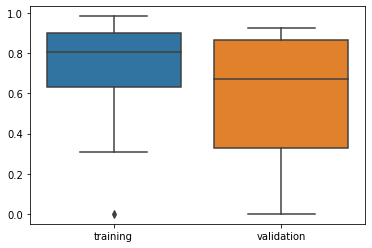

In [33]:
sns.boxplot(x=["training"]*cv_folds+["validation"]*cv_folds,y=training_score_list+validation_score_list);

In [34]:
pred = [x.flatten() for x in model.predict(valid_dataset)]

In [35]:
pred

[array([0.99739605, 0.00260392], dtype=float32),
 array([9.9929315e-01, 7.0692453e-04], dtype=float32),
 array([9.9982524e-01, 1.7477434e-04], dtype=float32),
 array([0.99003506, 0.00996487], dtype=float32),
 array([0.9978137 , 0.00218629], dtype=float32),
 array([0.9930767 , 0.00692337], dtype=float32),
 array([0.9867052, 0.0132949], dtype=float32),
 array([0.99819773, 0.00180215], dtype=float32),
 array([0.98531044, 0.01468951], dtype=float32),
 array([0.99182224, 0.00817765], dtype=float32),
 array([0.9986564 , 0.00134357], dtype=float32),
 array([9.991629e-01, 8.370740e-04], dtype=float32),
 array([9.994659e-01, 5.341509e-04], dtype=float32),
 array([0.9781635 , 0.02183648], dtype=float32),
 array([9.9905926e-01, 9.4080635e-04], dtype=float32),
 array([9.9913740e-01, 8.6254283e-04], dtype=float32),
 array([0.9974655 , 0.00253448], dtype=float32),
 array([0.9902025, 0.0097975], dtype=float32),
 array([0.98243135, 0.01756861], dtype=float32),
 array([0.998983  , 0.00101695], dtype=fl

In [36]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])

In [37]:
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids

In [38]:
pred_df.head()

,neg,pos,active,SMILES
0,0.997396,0.002604,0,CCN1c2ccccc2[C@]3(C1=O)[C@H]4C(=O)NC(=O)N=C4OC...
1,0.999293,0.000707,0,C[C@@H](C(=O)c1ccc(cc1)NC(=O)C(C)C)OC(=O)c2ccc...
2,0.999825,0.000175,0,CCCC(=O)N([C@H](c1c(cc(cc1O)O)O)C(=O)NC(C)(C)C...
3,0.990035,0.009965,0,COC(=O)Cn\1c2ccc(cc2s/c1=N\C(=O)c3ccc(cc3)N4C(...
4,0.997814,0.002186,0,Cc1ccc(cc1)SCc2cc(=O)nc([nH]2)/N=C(/N)\Nc3ccc(...


In [ ]:
pred_df.sort_values("pos",ascending=False).head(25)

,neg,pos,active,SMILES
11,0.168709,0.831291,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)...
51,0.224174,0.775826,1,CNC(=O)c1c2c(n(n1)C)-c3c(cnc(n3)NC4CCN(CC4)C(=...
37,0.242673,0.757327,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NCCc4...
45,0.348649,0.651351,1,CC1CNC(=O)c2c1c3cc(ccc3[nH]2)C(=O)Nc4cccnc4
16,0.377212,0.622788,0,c1ccc(cc1)[C@@]2(CCN(C2)c3c(ncc(n3)c4cc[nH]n4)N)O
290,0.593046,0.406954,0,c1c2c([nH]n1)nc(nc2N3CCC4(CC3)C(=O)N=C(N4)C5CC5)N
95,0.652636,0.347364,0,Cc1cc(c2c(c1)nc(c(=O)[nH]2)NC(=S)N)C
300,0.691353,0.308647,0,c1ccc(cc1)[C@H]2CCCN(CC2)c3ccc4nnc(n4n3)C(F)(F)F
137,0.748601,0.251399,0,c1ccc(cc1)c2nc([nH]n2)CN3c4ccccc4N[C@@H]3C5CC5
187,0.756580,0.243420,1,CCNC(=O)Nc1ccc(cn1)CNc2c(scn2)C(=O)Nc3ccc4c(c3...


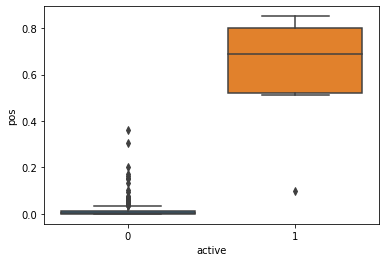

In [39]:
sns.boxplot(x=pred_df.active,y=pred_df.pos)

In [43]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()

In [44]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")

,neg,pos,active,SMILES,Mol
339,0.900314,0.099686,1,CC1CNC(=O)c2c1c3cc(ccc3[nH]2)C(=O)Nc4nc(cs4)C(...,

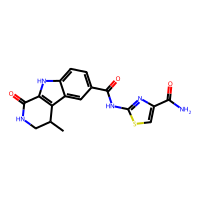

In [45]:
false_negative_df

In [49]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")

In [50]:
false_positive_df

,neg,pos,active,SMILES,Mol


In [51]:
model.fit(dataset)

0.0014402713626623155

In [68]:
pip install git+https://github.com/PatWalters/rd_filters.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-m9qs_lc3
  Running command git clone --filter=blob:none --quiet https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-m9qs_lc3
  Resolved https://github.com/PatWalters/rd_filters.git to commit 5f70235b387baa39669f25d95079e5dfec49a47c
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for rd-filters: filename=rd_filters-0.1-py3-none-any.whl size=33802 sha256=d5bddbc43764205779bb5789daa34e409d4f23f2a03c6b5bb8d328d847ec4d0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5z_id5sd/wheels/aa/39/1b/ad90770606b00524af935663da8e63a4b2035be2fe7ca6fd34
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=c516818d409db0d76ef7b2ef7375cb22184157ac06e4a8ba25839254e74a7a9e
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137

In [79]:
!pip install git+https://github.com/PatWalters/rd_filters.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-axik58_s
  Running command git clone --filter=blob:none --quiet https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-axik58_s
  Resolved https://github.com/PatWalters/rd_filters.git to commit 5f70235b387baa39669f25d95079e5dfec49a47c
  Preparing metadata (setup.py) ... done


In [80]:
!rd_filters -h

Usage:
rd_filters filter --in INPUT_FILE --prefix PREFIX [--rules RULES_FILE_NAME] [--alerts ALERT_FILE_NAME][--np NUM_CORES]
rd_filters template --out TEMPLATE_FILE [--rules RULES_FILE_NAME]

Options:
--in INPUT_FILE input file name
--prefix PREFIX prefix for output file names
--rules RULES_FILE_NAME name of the rules JSON file
--alerts ALERTS_FILE_NAME name of the structural alerts file
--np NUM_CORES the number of cpu cores to use (default is all)
--out TEMPLATE_FILE parameter template file name


In [81]:
!rd_filters filter --in zinc_100k.smi --prefix zinc

using 2 cores
Using alerts from Inpharmatica
Wrote SMILES for molecules passing filters to zinc.smi
Wrote detailed data to zinc.csv
68410 of 100000 passed filters 68.4%
Elapsed time 53.85 seconds


In [82]:
import pandas as pd

In [84]:
df = pd.read_csv("zinc.csv")

In [85]:
df.head()

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,Filter82_pyridinium > 0,311.342,-2.2813,2,9,105.52,6
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,Filter9_metal > 0,307.100,-1.0602,3,6,104.55,2
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,Filter82_pyridinium > 0,307.310,-1.7075,0,8,91.36,2
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.382,-1.0163,0,5,64.17,3
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,OK,302.327,-1.1355,3,6,106.12,4


In [87]:
from collections import Counter
count_list = list(Counter(df.FILTER).items())
count_df = pd.DataFrame(count_list,columns=["Rule","Count"])
count_df.sort_values("Count",inplace=True,ascending=False)
count_df.head()

,Rule,Count
2,OK,69148
7,Filter41_12_dicarbonyl > 0,19330
0,Filter82_pyridinium > 0,7713
11,Filter93_acetyl_urea > 0,1541
12,Filter78_bicyclic_Imide > 0,825


In [88]:
smiles_list = df[df.FILTER == "Filter41_12_dicarbonyl > 0"].SMILES[:10]

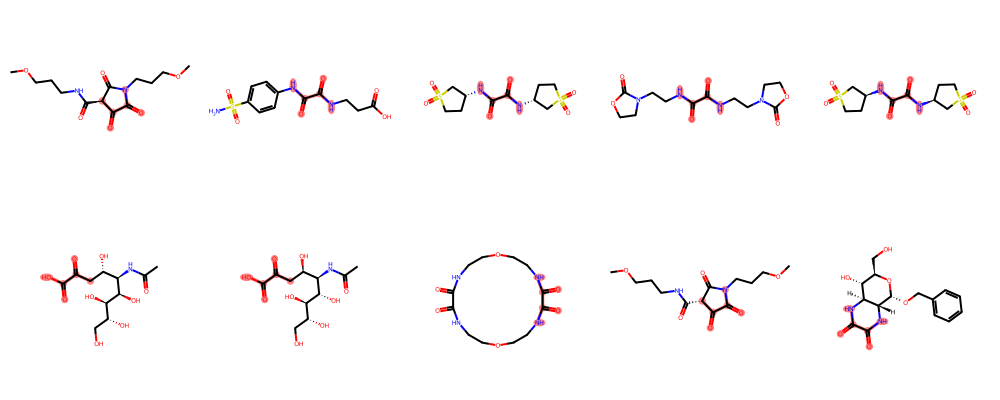

In [89]:
from rdkit import Chem
from rdkit.Chem import Draw

mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
dicarbonyl = Chem.MolFromSmarts('*C(=O)C(=O)*')
match_list = [mol.GetSubstructMatch(dicarbonyl) for mol in mol_list]
Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list,molsPerRow=5)

In [90]:
import deepchem as dc
import pandas as pd
from rdkit.Chem import PandasTools, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
import seaborn as sns

In [91]:
model = dc.models.GraphConvModel(1, batch_size=128, mode='classification',model_dir="model_dir")
model.restore()

In [92]:
featurizer = dc.feat.ConvMolFeaturizer()

In [93]:
df = pd.read_csv("zinc_100k.smi",sep=" ",header=None)

In [94]:
df.columns=["SMILES","Name"]

In [95]:
rows,cols = df.shape
df["Val"] = [0] * rows #just add add a dummy column to keep the featurizer happy

In [96]:
df.head()

,SMILES,Name,Val
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,0
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,0
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,0
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0


In [97]:
infile_name = "zinc_filtered.csv"
df.to_csv(infile_name,index=False)

In [98]:
loader = dc.data.CSVLoader(tasks=['Val'], feature_field="SMILES", featurizer=featurizer)

In [99]:
dataset = loader.create_dataset(infile_name, shard_size=8192)

In [100]:
pred = model.predict(dataset)

In [101]:
pred_df = pd.DataFrame([x.flatten() for x in pred],columns=["Neg","Pos"])

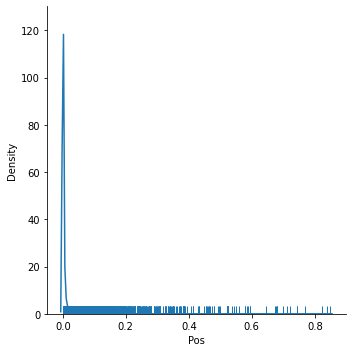

In [102]:
sns.displot(x=pred_df.Pos,kind="kde",rug=True)

In [104]:
combo_df = df.join(pred_df,how="outer")

In [105]:
combo_df.sort_values("Pos",inplace=True,ascending=False)

In [106]:
PandasTools.AddMoleculeColumnToFrame(combo_df,"SMILES","Mol")

In [107]:
combo_df.head()

,SMILES,Name,Val,Neg,Pos,Mol
50881,O=C(NCCO)c1ccc(=NCCN=c2cncc[nH]2)[nH]n1,ZINC000488377662,0,0.151512,0.848488,<rdkit.Chem.rdchem.Mol object at 0x7f6301a556d0>
52412,Cn1ccc(=NCCN=c2ccc(C(=O)NCCO)n[nH]2)[nH]1,ZINC000514934309,0,0.161807,0.838193,<rdkit.Chem.rdchem.Mol object at 0x7f6301a557b0>
84,OCN(CO)c1nc(N(CO)CO)nc(N(CO)CO)n1,ZINC000001708610,0,0.178299,0.821701,<rdkit.Chem.rdchem.Mol object at 0x7f6301a55820>
20419,O=C(NCCO)c1ccc(N2CCN(CCCO)CC2)nn1,ZINC000340048447,0,0.231333,0.768667,<rdkit.Chem.rdchem.Mol object at 0x7f6301a55890>
51015,NC(=O)c1ccc(CNc2ccc(C(=O)NCCO)nn2)cn1,ZINC000490078432,0,0.254990,0.745010,<rdkit.Chem.rdchem.Mol object at 0x7f6301a55900>


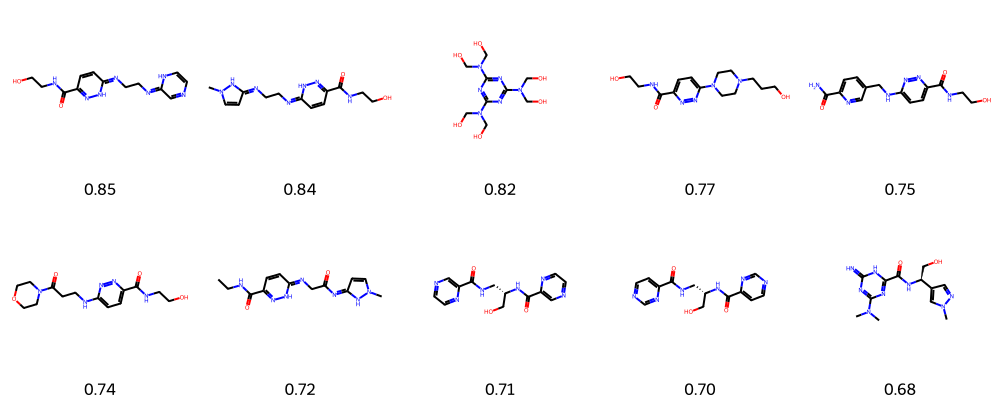

In [108]:
Draw.MolsToGridImage(combo_df.Mol[:10],molsPerRow=5,legends=["%.2f" % x for x in combo_df.Pos[:10]])